# Imports
    
    

    

In [24]:
import os, sys

# Set absolute path to the root folder of the directory
full_path = os.getcwd()
home_folder = 'CPS_GradRate_Analysis'
root = full_path.split(home_folder)[0] + home_folder + '/'
sys.path.append(root)


import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

import sklearn.pipeline
from sklearn.linear_model import LinearRegression

from statsmodels.graphics.gofplots import qqplot


from src.preprocessing.preprocessing_schoolid import merge_pr_and_sp
from src.preprocessing.preprocessing_schoolid import create_df_for_modeling
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Import and Train Test Split

In [17]:
path_to_sp_csv = '../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Profile_Information_SY1819.csv'
path_to_pr_csv = '../../data/chicago_data_portal_csv_files/Chicago_Public_Schools_-_School_Progress_Reports_SY1819.csv'

hs_201819 = merge_pr_and_sp(path_to_sp_csv, path_to_pr_csv)


In [18]:
from sklearn.model_selection import train_test_split, cross_validate

X = hs_201819.drop('Graduation_Rate_School', axis=1)
y = hs_201819.loc[:,'Graduation_Rate_School']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [19]:
train_df = X_train.merge(y_train, left_index=True, right_index=True)

In [20]:
train_df = create_df_for_modeling(train_df)

In [21]:
X_train = train_df.drop('Graduation_Rate_School', axis=1)
y_train = train_df['Graduation_Rate_School']

Find the first simple model in the fsm.ipynb notebook in the same folder as this notebook. It is a simple linear regression which predicts graduation rates of schools in the 2018-19 school year with Student Count Total.   The FSM's R^2 was .186 average across 3 fold crossvalidation.  Student Count Total had a coefficient of .0145, which can be understood as: for every 100 students, the graduation rate goes increases by 1.45 points.

### Cross Validation Function

In [55]:
def cps_cross_validate(exogenous_feature_name_list, estimator=LinearRegression()):
    cv = cross_validate(estimator, X_train[exogenous_feature_name_list], y_train, 
                        cv=5, return_train_score=True)
    print('##########train mean R^2#############')
    print(np.mean(cv['train_score']))
    print('##########teast mean R^2#############')
    print(np.mean(cv['test_score']))
    print('#####################################')
    print(cv['train_score'])
    print(cv['test_score'])
    print('##########Coefficients after fit on entire train #############')
    
    # When a pipeline is used, the name_steps have to be extracted from the pipeline object.  
    # The else statement below takes care of that.
    
    if type(estimator) != sklearn.pipeline.Pipeline:
        
        model = estimator
        model.fit(X_train[exogenous_feature_name_list], y_train)
        for coef, col in zip (model.coef_, exogenous_feature_name_list):
            print(coef, col)

        y_hat_train = model.predict(X_train[exogenous_feature_name_list])
        resids = y_train - y_hat_train

        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,7))
        ax1.scatter(y_hat_train, resids)
        
        qqplot(resids, ax=ax2, line='q')
        
    
    else: 
        model = estimator
        model.fit(X_train[exogenous_feature_name_list], y_train)
        for coef, col in zip (model.named_steps['linearregression'].coef_, exogenous_feature_name_list):
            print(coef, col)

        y_hat_train = model.predict(X_train[exogenous_feature_name_list])
        resids = y_train - y_hat_train

        fig, (ax1,ax2) = plt.subplots(2,1, figsize=(7,7))
        ax1.scatter(y_hat_train, resids)        
        
        ax1.scatter(y_hat_train, resids)
        
        qqplot(resids, ax=ax2, line='q')


##########train mean R^2#############
0.20410160794947468
##########teast mean R^2#############
0.12394979926958487
#####################################
[0.24468487 0.24534349 0.18518471 0.17538996 0.16990501]
[ 0.03757531 -0.11925122  0.24051018  0.15324784  0.30766688]
##########Coefficients after fit on entire train #############
0.009141668216549536 Student_Count_Total


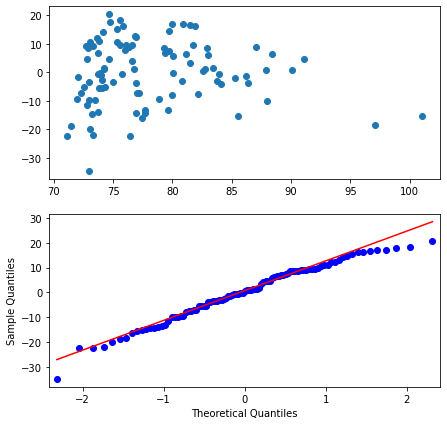

In [38]:
cps_cross_validate(['Student_Count_Total'])

# Model Iterations

## Add Percent Low Income

Next, I will add a percent low income students to the model.  This will help quantify how 

In [39]:
X_train['perc_low_income']

284    0.960870
73     0.752475
66     0.749803
260    0.772727
23     0.857143
         ...   
560    0.827755
313    0.803797
160    0.850156
276    0.948787
20     0.800718
Name: perc_low_income, Length: 97, dtype: float64

##########train mean R^2#############
0.27649145739968545
##########teast mean R^2#############
0.16844662643285563
#####################################
[0.30204998 0.31263943 0.2191205  0.26828322 0.28036415]
[ 0.14380646 -0.02891625  0.44163658  0.06727258  0.21843376]
##########Coefficients after fit on entire train #############
0.005869482093474047 Student_Count_Total
-27.13956593676595 perc_low_income


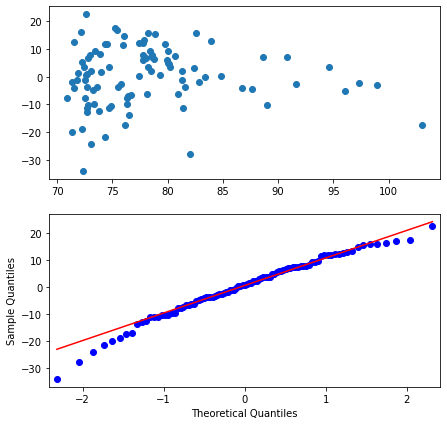

In [40]:
cps_cross_validate(['Student_Count_Total', 'perc_low_income'])

> adding percent low income results in a significant increase in both train and validation R^2.

## Add Dress Code

##########train mean R^2#############
0.2792826947671993
##########teast mean R^2#############
0.15347326359334862
#####################################
[0.30378401 0.31270946 0.22711956 0.27145317 0.28134727]
[ 0.14304659 -0.02687326  0.39574529  0.05389571  0.20155199]
##########Coefficients after fit on entire train #############
0.006131898838802494 Student_Count_Total
-28.325793332508454 perc_low_income
1.0413104968888691 Dress_Code


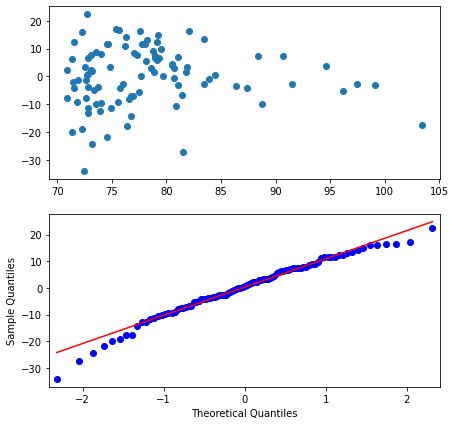

In [41]:
cps_cross_validate(['Student_Count_Total', 'perc_low_income', 'Dress_Code'])

> Adding dress code improves the train score, but validation scores actually go down a bit.

## Add Creative School Certification

EDA suggested that a Creative School Certification correlates with higher graduation rates. 

In [42]:
X_train.columns[X_train.columns.str.startswith('creative')]

Index(['creative_DEVELOPING', 'creative_EXCELLING', 'creative_INCOMPLETE DATA',
       'creative_STRONG'],
      dtype='object')

In [43]:
exog = ['Student_Count_Total', 'perc_low_income', 'Dress_Code']

In [44]:
exog.extend(
    list(X_train.columns[X_train.columns.str.startswith('creative')]))

In [45]:
exog

['Student_Count_Total',
 'perc_low_income',
 'Dress_Code',
 'creative_DEVELOPING',
 'creative_EXCELLING',
 'creative_INCOMPLETE DATA',
 'creative_STRONG']

##########train mean R^2#############
0.330159864774311
##########teast mean R^2#############
0.13748996181745932
#####################################
[0.36560536 0.34806259 0.26945042 0.33303191 0.33464905]
[ 0.08584008  0.03414307  0.4504288  -0.06901555  0.1860534 ]
##########Coefficients after fit on entire train #############
0.004368188955616686 Student_Count_Total
-27.320632304686512 perc_low_income
0.8433855494641589 Dress_Code
3.492433370278744 creative_DEVELOPING
7.458665450487075 creative_EXCELLING
12.160907231353773 creative_INCOMPLETE DATA
5.025907631942957 creative_STRONG


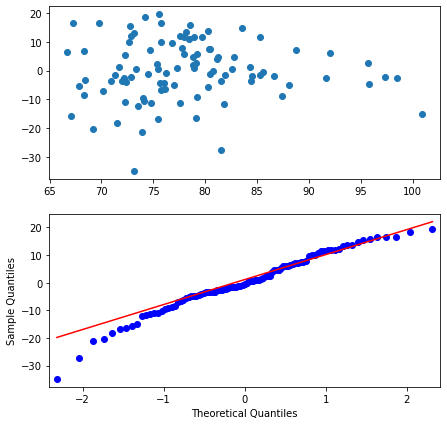

In [46]:
cps_cross_validate(exog)

## Add teacher attendance


In [47]:
X_train['teacher_attendance']

284      NaN
73     93.65
66     95.70
260    94.55
23     92.95
       ...  
560    94.25
313      NaN
160      NaN
276      NaN
20       NaN
Name: teacher_attendance, Length: 97, dtype: float64

In [48]:
X_train['Teacher_Attendance_Year_2_Pct'].isna().sum()

32

In [49]:
exog = ['Student_Count_Total', 'perc_low_income', 'Dress_Code', 'teacher_attendance']

In [50]:
exog.extend(
    list(X_train.columns[X_train.columns.str.startswith('creative')]))

The teacher_attendance variable requires imputation, since there are 44 nan values.  To prevent data leakage in the cross validation, I will make use of a pipeline.  A simple imputer will apply the imputation correctly across the folds.

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [52]:
ta_pipe = make_pipeline(SimpleImputer(), LinearRegression())

In [53]:
ta_pipe.fit(X_train[['teacher_attendance']], y_train).named_steps['linearregression'].coef_

array([6.5634926])

##########train mean R^2#############
0.4028965897366007
##########teast mean R^2#############
0.20535052957067207
#####################################
[0.39249572 0.42400898 0.3742811  0.41371051 0.40998664]
[ 0.28076557  0.08353311  0.40431821 -0.01376877  0.27190454]
##########Coefficients after fit on entire train #############
0.004891755165974641 Student_Count_Total
-20.412934931264164 perc_low_income
-0.14130625034635727 Dress_Code
4.904614991870853 teacher_attendance
1.4787916659636162 creative_DEVELOPING
4.824066034398563 creative_EXCELLING
10.614138766156504 creative_INCOMPLETE DATA
4.495281348996687 creative_STRONG


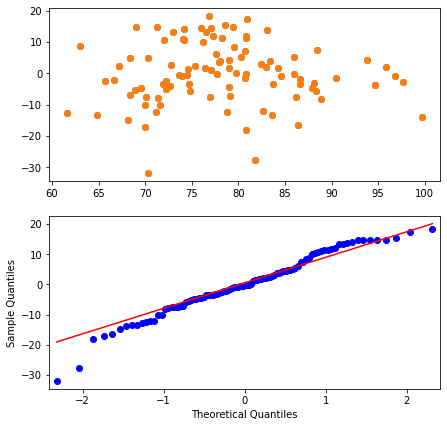

In [56]:
cps_cross_validate(exog, ta_pipe)

Both the training and valdiation scores continue to increase by approximately 7 pts from the previous model.

There continues to be high variance, however. The train and validation splits have an approximately 20 pt difference.